In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import datetime as dt
import re

import warnings
warnings.filterwarnings('ignore')

In [3]:
# get pandas data 



# Veri Yükleme ve Temizleme

In [4]:
file_path_2009_2010 = "data/year_2009_2010.csv"
file_path_2010_2011 = "data/year_2010_2011.csv"

 

In [5]:
# Dosyaları okuma
df1 = pd.read_csv(file_path_2009_2010,encoding='iso-8859-1')
df2 = pd.read_csv(file_path_2010_2011, encoding='iso-8859-1')


# DataFrame'leri birleştirme
df = pd.concat([df1, df2], ignore_index=True)

In [6]:
missing_data = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Eksik verileri ve oranlarını tabloya çevirme
missing_data_df = pd.DataFrame({
    'Eksik Veri Sayısı': missing_data,
    'Eksik Veri Oranı (%)': missing_percentage
})

# Eksik verileri ve oranlarını yazdırma
print("\nEksik veriler ve oranları:")
print(missing_data_df)


# Eksik verileri silme
df.dropna(inplace=True)


Eksik veriler ve oranları:
             Eksik Veri Sayısı  Eksik Veri Oranı (%)
Invoice                      0              0.000000
StockCode                    0              0.000000
Description               4382              0.410541
Quantity                     0              0.000000
InvoiceDate                  0              0.000000
Price                        0              0.000000
Customer ID             243007             22.766873
Country                      0              0.000000


In [7]:
# InvoiceNo 'C' ile başlayanları çıkarma
df = df[~df['Invoice'].str.startswith('C', na=False)]

# Fatura iptallerini çıkarma
df = df[~df['Invoice'].str.startswith('C')]

# Negatif ve sıfır miktar ve fiyatları çıkarma
# Negatif miktar ve fiyatları çıkar
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

In [8]:
# StockCode ve Description sütunlarını string tipine çevirme
df["StockCode"] = df["StockCode"].astype(str)
df["Description"] = df["Description"].astype(str)

# Benzersiz StockCode ve Description eşleşmelerini bulma
df_product = df[["StockCode", "Description"]].drop_duplicates()

# StockCode başına birden fazla Description olup olmadığını kontrol etme
stockcode_count = df_product['StockCode'].value_counts()
duplicate_stockcodes = stockcode_count[stockcode_count > 1].index

# Description başına birden fazla StockCode olup olmadığını kontrol etme
description_count = df_product['Description'].value_counts()
duplicate_descriptions = description_count[description_count > 1].index

# Bu duplicate StockCode'ları ve Description'ları gözden geçirme
duplicates = df_product[df_product['StockCode'].isin(duplicate_stockcodes) | df_product['Description'].isin(duplicate_descriptions)]

print("Duplicate StockCodes and Descriptions:")
print(duplicates)

Duplicate StockCodes and Descriptions:
        StockCode                         Description
2          79323W                 WHITE CHERRY LIGHTS
4           21232      STRAWBERRY CERAMIC TRINKET BOX
7           21523  FANCY FONT HOME SWEET HOME DOORMAT
8           22350                           CAT BOWL 
9           22349      DOG BOWL , CHASING BALL DESIGN
...           ...                                 ...
1008823    84206B      CAT WITH SUNGLASSES BLANK CARD
1017336     71053        WHITE MOROCCAN METAL LANTERN
1029183     21175       GIN AND TONIC DIET METAL SIGN
1030162    90014C     SILVER AND BLACK ORBIT NECKLACE
1063082    85123A  CREAM HANGING HEART T-LIGHT HOLDER

[1353 rows x 2 columns]


In [9]:

# Her StockCode için en sık kullanılan Description'ı seçme
most_frequent_descriptions = df.groupby('StockCode')['Description'].agg(lambda x: x.value_counts().index[0]).reset_index()
df = df.drop(columns=['Description']).merge(most_frequent_descriptions, on='StockCode', how='left')

# Her Description için en sık kullanılan StockCode'u seçme
most_frequent_stockcodes = df.groupby('Description')['StockCode'].agg(lambda x: x.value_counts().index[0]).reset_index()
df = df.drop(columns=['StockCode']).merge(most_frequent_stockcodes, on='Description', how='left')

In [10]:
# Son durumda benzersiz StockCode ve Description sayıları
unique_stockcodes_cleaned = df['StockCode'].nunique()
unique_descriptions_cleaned = df['Description'].nunique()

print("Temizlenmiş Veride Benzersiz StockCode sayısı:", unique_stockcodes_cleaned)
print("Temizlenmiş Veride Benzersiz Description sayısı:", unique_descriptions_cleaned)

Temizlenmiş Veride Benzersiz StockCode sayısı: 4605
Temizlenmiş Veride Benzersiz Description sayısı: 4605


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805549 entries, 0 to 805548
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      805549 non-null  object 
 1   Quantity     805549 non-null  int64  
 2   InvoiceDate  805549 non-null  object 
 3   Price        805549 non-null  float64
 4   Customer ID  805549 non-null  float64
 5   Country      805549 non-null  object 
 6   Description  805549 non-null  object 
 7   StockCode    805549 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 49.2+ MB


In [12]:
df.to_csv("data/cleaned_data.csv", index=False)

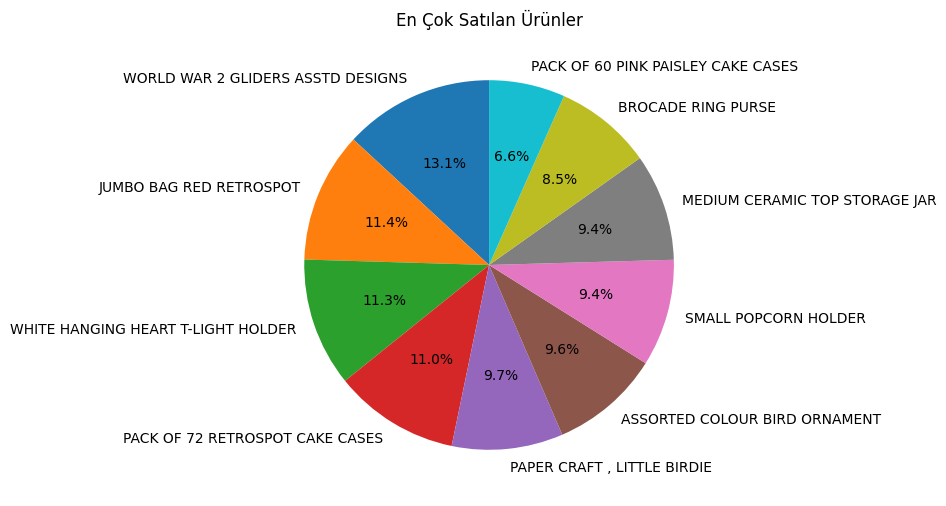

In [25]:
# En çok satılan ürünlerin grafiği
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
top_products.plot(kind='pie', autopct='%1.1f%%', startangle=90, shadow=False, labels=top_products.index)
plt.title('En Çok Satılan Ürünler')
plt.ylabel('')  
plt.show()

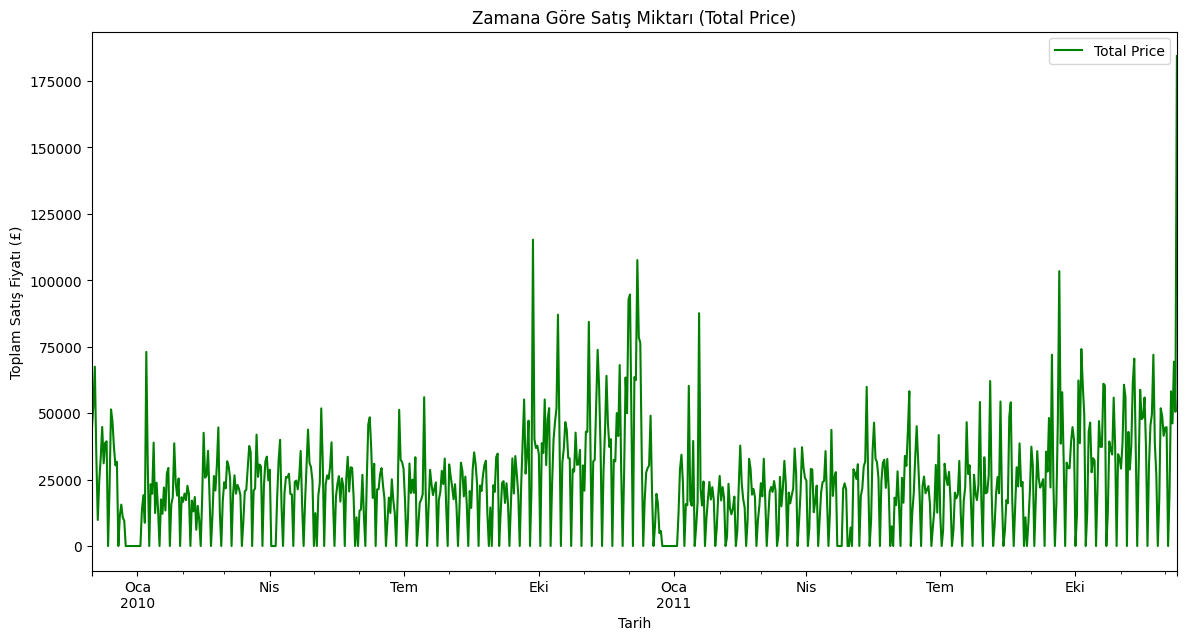

In [29]:

# TotalPrice sütununu oluştur
df['TotalPrice'] = df['Quantity'] * df['Price']

# Zamana göre Quantity ve TotalPrice hesaplama
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

sales_by_date_totalprice = df.set_index('InvoiceDate').resample('D')['TotalPrice'].sum()

# Zamana göre TotalPrice grafiği
plt.figure(figsize=(14, 7))
sales_by_date_totalprice.plot(label='Total Price', color='green')
plt.title('Zamana Göre Satış Miktarı (Total Price)')
plt.xlabel('Tarih')
plt.ylabel('Toplam Satış Fiyatı (£)')
plt.legend()
plt.show()

# Müşteri Segmentasyonu RFM Analizi

In [14]:

# Fatura tarihlerini datetime formatına çevir
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# En son işlem tarihini belirle
current_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Toplam Satış Tutarı (Revenue)
df['TotalPrice'] = df['Quantity'] * df['Price']


# RFM Değerlerini Hesapla
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda date: (current_date - date.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

rfm.head()

,Customer ID,Recency,Frequency,Monetary
0,12346.0,326,12,77556.46
1,12347.0,2,8,5633.32
2,12348.0,75,5,2019.40
3,12349.0,19,4,4428.69
4,12350.0,310,1,334.40


In [15]:



# RFM Skorlarını Hesapla
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])





# RFM Skoru
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

  
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can not Loose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
} 
 

# Ensure 'RFM_Score' is a string for regex matching
rfm['RFM_Score'] = rfm['RFM_Score'].astype(str)

# Function to map RFM_Score to segments
def map_segment(rfm_score):
    for pattern, segment in seg_map.items():
        if re.match(pattern, rfm_score):
            return segment
    return None  # or return a default segment if no match is found

# Apply the mapping function to the 'RFM_Score' column
rfm['Segment'] = rfm['RFM_Score'].apply(map_segment)

rfm.head()

,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,12346.0,326,12,77556.46,2,5,5,255,Can not Loose
1,12347.0,2,8,5633.32,5,4,5,545,Champions
2,12348.0,75,5,2019.40,3,4,4,344,Loyal Customers
3,12349.0,19,4,4428.69,5,3,5,535,Potential Loyalists
4,12350.0,310,1,334.40,2,1,2,212,Hibernating


In [16]:
rfm.groupby('Segment').agg({"Customer ID":"count"}).sort_values("Customer ID",ascending=False)

,Customer ID
Segment,
Hibernating,1523
Loyal Customers,1161
Champions,837
At Risk,753
Potential Loyalists,714
About to Sleep,385
Need Attention,266
Promising,114
Can not Loose,71


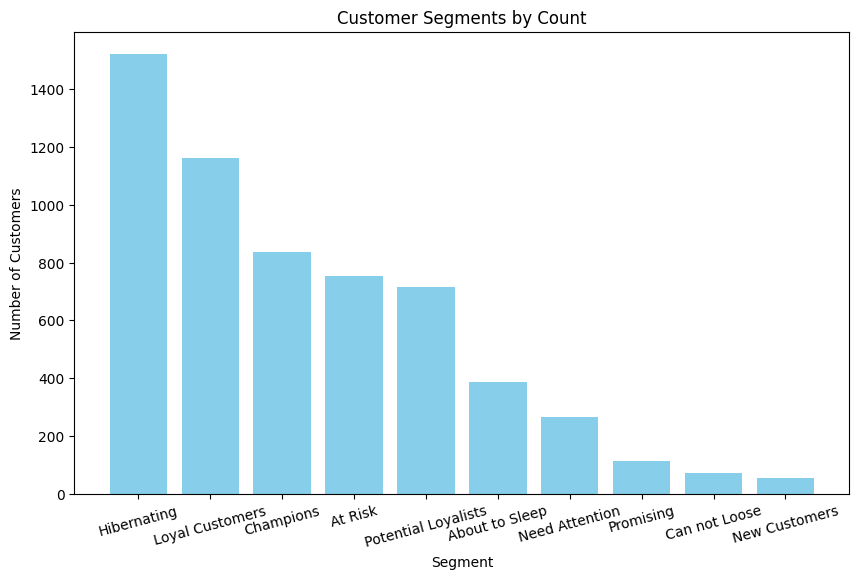

In [17]:
# Aggregate and sort the data
segment_counts = rfm.groupby('Segment').agg({"Customer ID": "count"}).sort_values("Customer ID", ascending=False)

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(segment_counts.index, segment_counts['Customer ID'], color='skyblue')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.title('Customer Segments by Count')
plt.xticks(rotation=15)
plt.show()

In [18]:
# Save the data
rfm.to_csv("data/rfm_results.csv", index=False)

RFM analizi (Recency, Frequency, Monetary) müşterileri farklı segmentlere ayırarak müşteri davranışlarını anlamak ve pazarlama stratejilerini geliştirmek için kullanılır. Elde ettiğiniz segment sonuçlarına göre yorumlar:

1. **Hibernating (1523 Müşteri):**
   - Bu segmentteki müşteriler, uzun süredir alışveriş yapmayan ve genellikle düşük harcama yapan müşterilerdir. Bu müşterileri yeniden kazanmak zor olabilir, ancak etkili yeniden hedefleme kampanyaları ile geri kazanılmaları mümkündür.

2. **Loyal Customers (1161 Müşteri):**
   - Bu segment, sık sık alışveriş yapan ve yüksek harcama yapan müşterilerden oluşur. Bu müşterileri elde tutmak çok önemlidir. Onlara özel teklifler, sadakat programları ve kişiselleştirilmiş hizmetler sunarak bağlılıklarını artırabilirsiniz.

3. **Champions (837 Müşteri):**
   - Şampiyon müşteriler, en değerli müşterilerinizdir. En son alışverişlerini yakın zamanda yapmış ve sık sık alışveriş yaparak yüksek harcama yapmışlardır. Bu müşterilere özel dikkat göstermeli ve VIP muamelesi yapmalısınız.

4. **At Risk (753 Müşteri):**
   - Risk altındaki müşteriler, geçmişte sık alışveriş yapan ancak son zamanlarda azalmış veya durdurmuş müşterilerdir. Bu müşterileri geri kazanmak için özel kampanyalar ve hatırlatma e-postaları göndermek faydalı olabilir.

5. **Potential Loyalists (714 Müşteri):**
   - Potansiyel sadık müşteriler, alışveriş sıklığını artıran ve potansiyel olarak sadık hale gelebilecek müşterilerdir. Bu müşterilere özel teklifler ve indirimler sunarak onları sadık müşterilere dönüştürebilirsiniz.

6. **About to Sleep (385 Müşteri):**
   - Uykuya dalmak üzere olan müşteriler, yakında hibernation durumuna geçebilecek müşterilerdir. Bu müşterilere ulaşmak ve tekrar alışveriş yapmalarını teşvik etmek için harekete geçmek önemlidir.

7. **Need Attention (266 Müşteri):**
   - İlgiye ihtiyaç duyan müşteriler, alışveriş sıklığı ve harcama miktarı azalmış olan müşterilerdir. Bu müşterilere kişiselleştirilmiş teklifler ve kampanyalar sunarak ilgilerini yeniden çekebilirsiniz.

8. **Promising (114 Müşteri):**
   - Umut vadeden müşteriler, potansiyel olarak değerli müşteriler olma yolunda ilerleyen, alışveriş sıklığını artıran ve harcama miktarını artıran müşterilerdir. Bu müşterileri sadakat programlarına dahil etmek faydalı olabilir.

9. **Can not Loose (71 Müşteri):**
   - Kaybedilmemesi gereken müşteriler, yüksek değerli ve sadık müşterilerdir. Bu müşterilere özel ilgi gösterilmeli ve bağlılıkları korunmalıdır. VIP programları ve kişiselleştirilmiş hizmetler sunmak iyi bir strateji olabilir.

10. **New Customers (54 Müşteri):**
    - Yeni müşteriler, henüz alışveriş deneyimleri sınırlı olan müşterilerdir. Bu müşterileri elde tutmak için hoş geldin kampanyaları, indirimler ve kişiselleştirilmiş öneriler sunarak iyi bir başlangıç yapmalarını sağlayabilirsiniz.

Bu segmentleri analiz ederek, her bir segment için özel pazarlama stratejileri geliştirebilir ve müşteri bağlılığını artırabilirsiniz. Bu şekilde, müşteri değerini maksimize edebilir ve işletmenizin gelirini artırabilirsiniz.